## Takeaway from this homework
* In order to initialize the NN to produce uniform outputs at the start of training, don't make the last layer to be completely zeros. If the neurons are zeros, then they have same gradient during backprobagation. This symmetry would prevent the network from learning diverse features
* It's not great if the distribution of tanh is mostly -1 or 1. This is because its grad=(1-t^2)*previous_grad will be 0. Backward pass will be stopped from this tanh unit. As a result, this neuron and the neurons depend on it will not learn. One way to avoid this issue is to scale down the hidden layer before tanh during the initialization. Or use Kaiming init.
* Kaiming init: maintain the variance of activations and gradients across layers by scaling, preventing the vanishing/exploding gradient problem, especially in deep networks with many layers.
* BatchNormalization basic idea: normalize the hidden layer before tanh.

# Setup

In [267]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [268]:
# download the names.txt file from github
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

--2024-09-03 06:10:55--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt.4’

names.txt.4         100%[===================>] 222.80K  --.-KB/s    in 0.03s   

2024-09-03 06:10:55 (7.58 MB/s) - ‘names.txt.4’ saved [228145/228145]



In [269]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

## Indexing

In [270]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


## Core ML

In [271]:
import random
from collections import OrderedDict

split_random_seed = 42 # for reproducibility
network_random_seed = 2147483647 # for reproducibility
block_size = 3

class Linear:

  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

def _build_dataset(words, block_size=3):
  """
  Builds the dataset based on block size.

  Parameters:
    words (list[str]): list of words

  Returns:
    (X, Y):  mappings from context of block size to the next character.
  """

  X, Y = [], []
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix]

  return torch.tensor(X), torch.tensor(Y)

def split_dataset(words, block_size=3, train_ratio=0.8, dev_ratio=0.1):
  """Splits dataset into train, dev, test"""

  random.seed(split_random_seed)
  random.shuffle(words)
  n1 = int(train_ratio*len(words))
  n2 = int((train_ratio+dev_ratio)*len(words))
  Xtr, Ytr = _build_dataset(words[:n1], block_size)
  Xdev, Ydev = _build_dataset(words[n1:n2], block_size)
  Xte, Yte = _build_dataset(words[n2:], block_size)

  return dict({
    'train': {'xs': Xtr, 'ys': Ytr},
    'dev': {'xs': Xdev, 'ys': Ydev},
    'test': {'xs': Xte, 'ys': Yte}
  })

def train(C_layers_parameters, Xtr, Ytr, trial_run=False, batch_size=32, max_steps=200000):
  lossi = []
  ud = []

  for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    C, layers, parameters = C_layers_parameters

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    x = emb.view(emb.shape[0], -1) # concatenate the vectors
    for layer in layers:
      x = layer(x)
    loss = F.cross_entropy(x, Yb) # loss function

    # backward pass
    for layer in layers:
      layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
    for p in parameters:
      p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
    for p in parameters:
      p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
      print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
      ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

    if i >= 1000 and trial_run:
      break # AFTER_DEBUG: would take out obviously to run full optimization

  return (lossi, ud)

@torch.no_grad() # this decorator disables gradient tracking
def split_loss(dataset, split, C, layers):
  x,y = {
    'train': (dataset['train']['xs'], dataset['train']['ys']),
    'val': (dataset['dev']['xs'], dataset['dev']['ys']),
    'test': (dataset['test']['xs'], dataset['test']['ys']),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

## Diagnostic Tools

In [272]:
def visualize_activation_distribution(layers):
  # visualize histograms
  plt.figure(figsize=(20, 4)) # width and height of the plot
  legends = []
  for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Tanh):
      t = layer.out
      print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
      hy, hx = torch.histogram(t, density=True)
      plt.plot(hx[:-1].detach(), hy.detach())
      legends.append(f'layer {i} ({layer.__class__.__name__}')
  plt.legend(legends);
  plt.title('activation distribution')

def visualize_gradient_distribution(layers):
  # visualize histograms
  plt.figure(figsize=(20, 4)) # width and height of the plot
  legends = []
  for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Tanh):
      t = layer.out.grad
      print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
      hy, hx = torch.histogram(t, density=True)
      plt.plot(hx[:-1].detach(), hy.detach())
      legends.append(f'layer {i} ({layer.__class__.__name__}')
  plt.legend(legends);
  plt.title('gradient distribution')

def visualize_weight_gradient_distribution(parameters):
  # visualize histograms
  plt.figure(figsize=(20, 4)) # width and height of the plot
  legends = []
  for i,p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
      print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
      hy, hx = torch.histogram(t, density=True)
      plt.plot(hx[:-1].detach(), hy.detach())
      legends.append(f'{i} {tuple(p.shape)}')
  plt.legend(legends)
  plt.title('weights gradient distribution');

## Common Setup

In [273]:
# Split data
dataset = split_dataset(words, block_size=block_size, train_ratio=0.8, dev_ratio=0.1)
Xtr, Ytr = dataset['train']['xs'], dataset['train']['ys']
Xdev, Ydev = dataset['dev']['xs'], dataset['dev']['ys']
Xtest, Ytest = dataset['test']['xs'], dataset['test']['ys']

# Exercise 1
*  I did not get around to seeing what happens when you initialize all weights and biases to zero. Try this and train the neural net. You might think either that 1) the network trains just fine or 2) the network doesn't train at all, but actually it is 3) the network trains but only partially, and achieves a pretty bad final performance. Inspect the gradients and activations to figure out what is happening and why the network is only partially training, and what part is being trained exactly.

**Answer:**
* Initialiazing all W and b to zeros yields pretty bad performance .. 2.82 compared to 2.13 on test set.
* Only the last layer is trained. It's because grad=derivative * prev_grad where prev_grad of last layer=1.


In [274]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(network_random_seed) # for reproducibility

def build_nn_ex1_base():
  C = torch.randn((vocab_size, n_embd),            generator=g)
  layers = [
    Linear(n_embd * block_size, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, vocab_size),
  ]

  parameters = [C] + [p for layer in layers for p in layer.parameters()]
  print(sum(p.nelement() for p in parameters)) # number of parameters in total
  for p in parameters:
    p.requires_grad = True

  return (C, layers, parameters)

def build_nn_ex1_zeros():
  C, layers, parameters = build_nn_ex1_base()

  with torch.no_grad():
    # zero all
    for layer in layers:
      if isinstance(layer, Linear):
        layer.weight *= 0
        layer.bias *= 0

  return (C, layers, parameters)

def build_nn_ex1_normal():
  C, layers, parameters = build_nn_ex1_base()

  with torch.no_grad():
    # last layer: make less confident
    layers[-1].weight *= 0.1
    layers[-1].bias *= 0

    # all other layers: apply gain
    for layer in layers[:-1]:
      if isinstance(layer, Linear):
        layer.weight *= 5/3

  return (C, layers, parameters)

## All Zeros

### Visualization @ init

In [275]:
%%capture
C_layers_parameters_ex1_zeros_init = build_nn_ex1_zeros()
train(C_layers_parameters_ex1_zeros_init, Xtr, Ytr, trial_run=True)

layer 1 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 3 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 5 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%


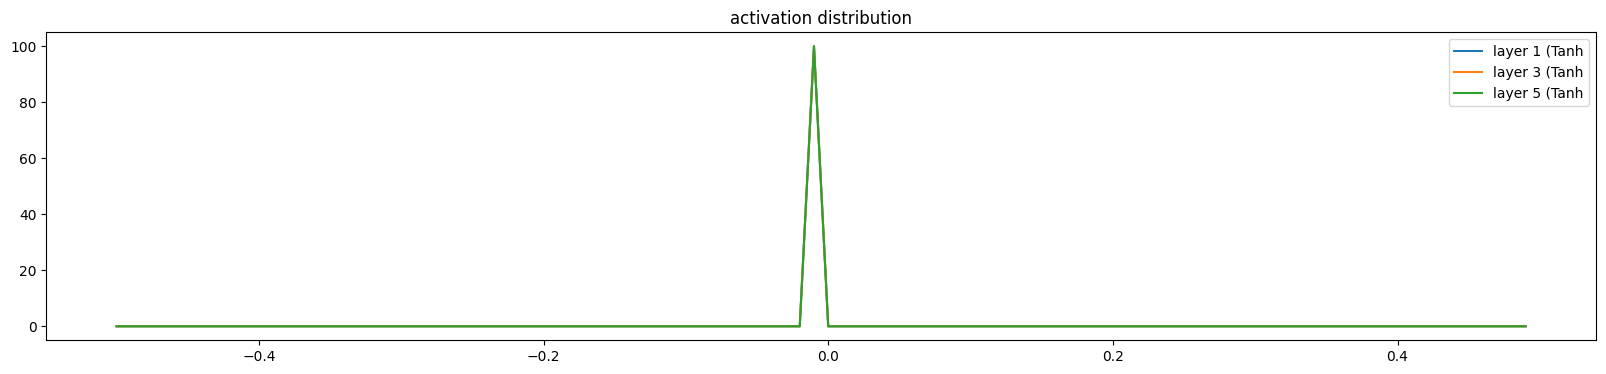

In [276]:
visualize_activation_distribution(C_layers_parameters_ex1_zeros_init[1])

layer 1 (      Tanh): mean +0.000000, std 0.000000e+00
layer 3 (      Tanh): mean +0.000000, std 0.000000e+00
layer 5 (      Tanh): mean +0.000000, std 0.000000e+00


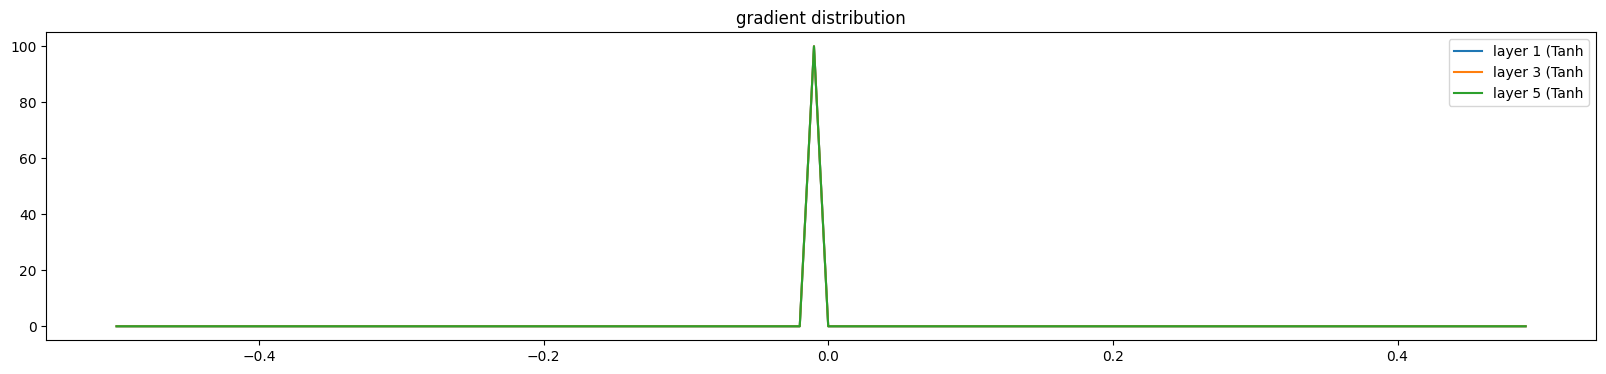

In [277]:
visualize_gradient_distribution(C_layers_parameters_ex1_zeros_init[1])

weight   (27, 10) | mean +0.000000 | std 0.000000e+00 | grad:data ratio 0.000000e+00
weight  (30, 100) | mean +0.000000 | std 0.000000e+00 | grad:data ratio nan
weight (100, 100) | mean +0.000000 | std 0.000000e+00 | grad:data ratio nan
weight (100, 100) | mean +0.000000 | std 0.000000e+00 | grad:data ratio nan
weight  (100, 27) | mean +0.000000 | std 0.000000e+00 | grad:data ratio nan


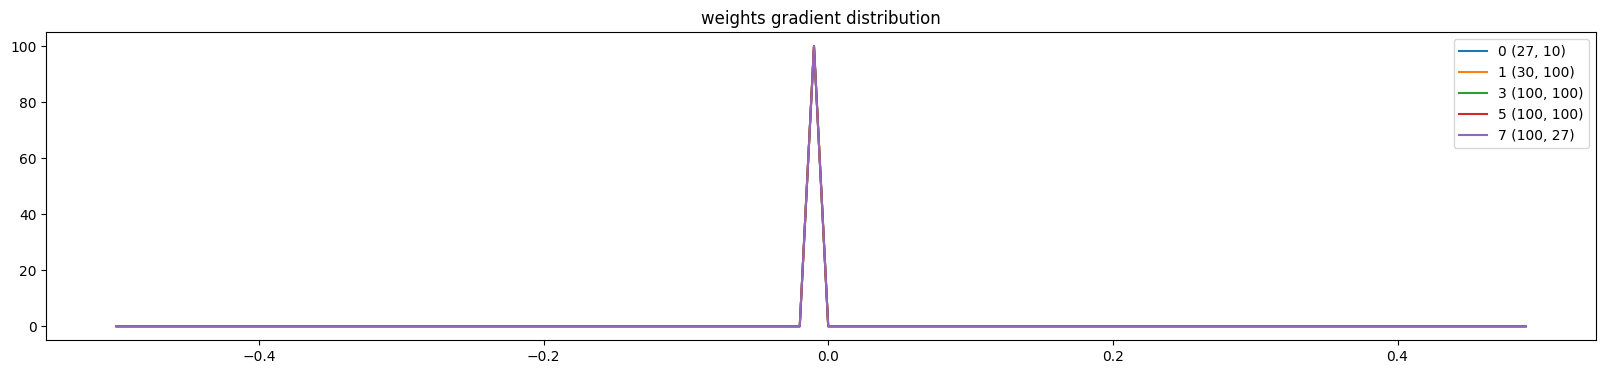

In [278]:
visualize_weight_gradient_distribution(C_layers_parameters_ex1_zeros_init[2])

In [279]:
# put layers into eval mode
for layer in C_layers_parameters_ex1_zeros_init[1]:
  layer.training = False
split_loss(dataset, 'train', C_layers_parameters_ex1_zeros_init[0], C_layers_parameters_ex1_zeros_init[1])
split_loss(dataset, 'test', C_layers_parameters_ex1_zeros_init[0], C_layers_parameters_ex1_zeros_init[1])

train 2.8331692218780518
test 2.8364620208740234


### Visualization @ train

In [280]:
C_layers_parameters_ex1_zeros_train = build_nn_ex1_zeros()
ex1_zeros_train_lossi, ex1_zeros_train_ud = train(C_layers_parameters_ex1_zeros_train, Xtr, Ytr)

26297
      0/ 200000: 3.2958
  10000/ 200000: 3.0515
  20000/ 200000: 2.6803
  30000/ 200000: 2.8811
  40000/ 200000: 2.6932
  50000/ 200000: 2.8148
  60000/ 200000: 2.7537
  70000/ 200000: 2.6755
  80000/ 200000: 2.5236
  90000/ 200000: 2.9927
 100000/ 200000: 2.6952
 110000/ 200000: 2.5502
 120000/ 200000: 2.8073
 130000/ 200000: 2.8619
 140000/ 200000: 2.8402
 150000/ 200000: 2.9233
 160000/ 200000: 2.8833
 170000/ 200000: 2.6639
 180000/ 200000: 2.8199
 190000/ 200000: 2.8919


layer 1 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 3 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 5 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%


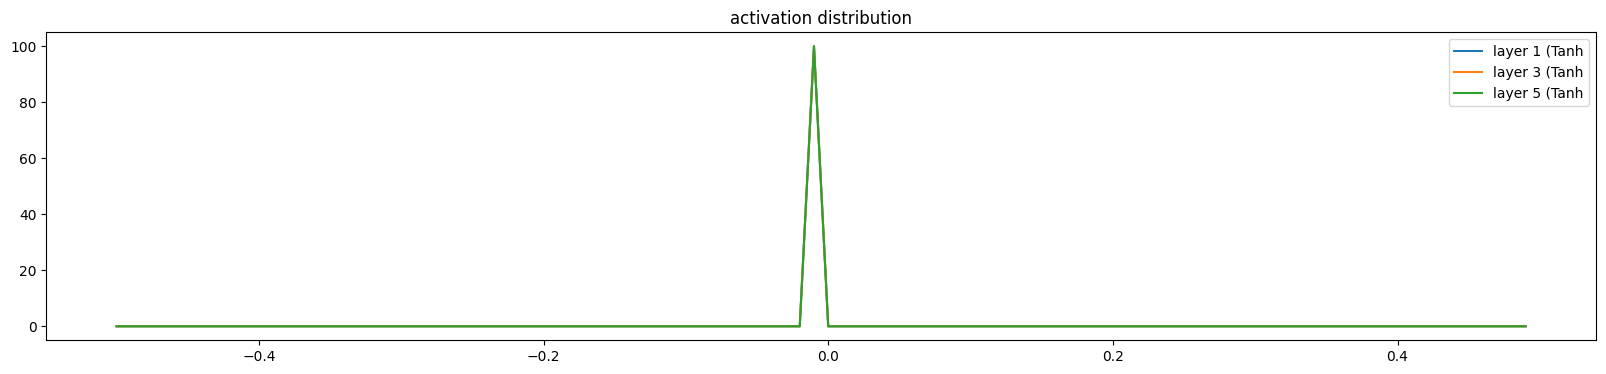

In [281]:
visualize_activation_distribution(C_layers_parameters_ex1_zeros_train[1])

layer 1 (      Tanh): mean +0.000000, std 0.000000e+00
layer 3 (      Tanh): mean +0.000000, std 0.000000e+00
layer 5 (      Tanh): mean +0.000000, std 0.000000e+00


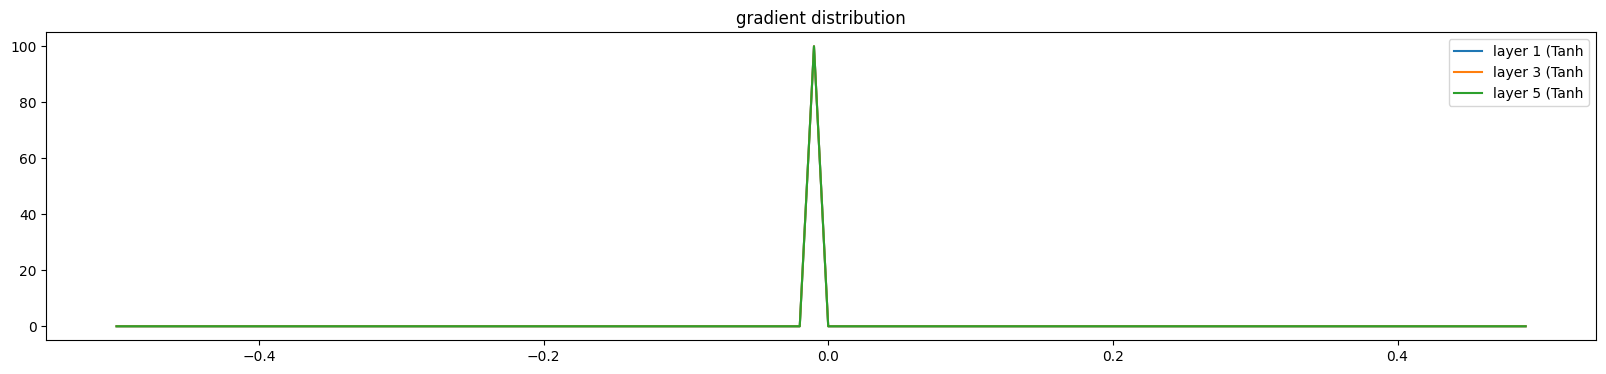

In [282]:
visualize_gradient_distribution(C_layers_parameters_ex1_zeros_train[1])

weight   (27, 10) | mean +0.000000 | std 0.000000e+00 | grad:data ratio 0.000000e+00
weight  (30, 100) | mean +0.000000 | std 0.000000e+00 | grad:data ratio nan
weight (100, 100) | mean +0.000000 | std 0.000000e+00 | grad:data ratio nan
weight (100, 100) | mean +0.000000 | std 0.000000e+00 | grad:data ratio nan
weight  (100, 27) | mean +0.000000 | std 0.000000e+00 | grad:data ratio nan


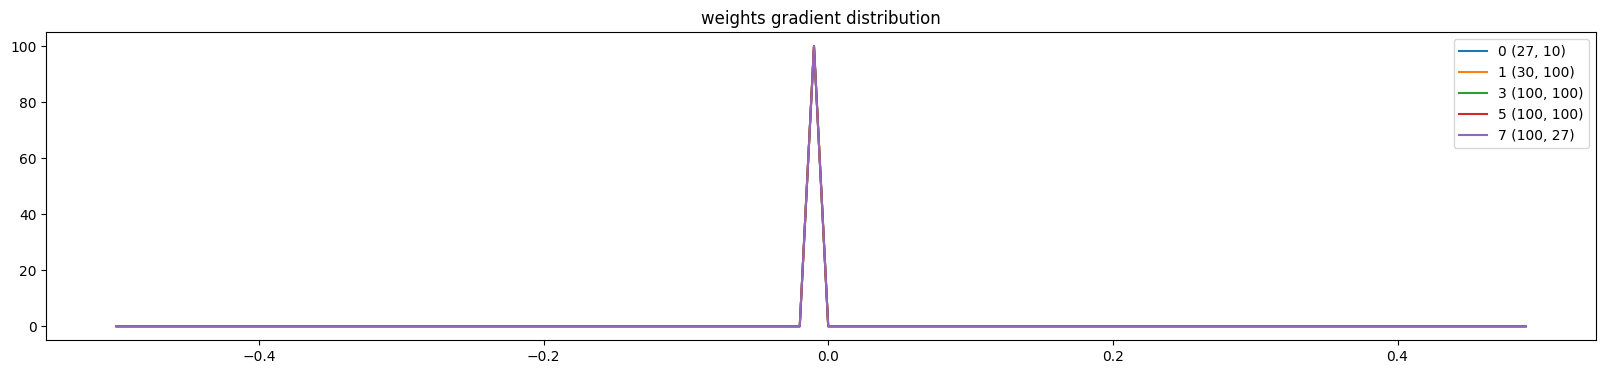

In [283]:
visualize_weight_gradient_distribution(C_layers_parameters_ex1_zeros_train[2])

In [284]:
# put layers into eval mode
for layer in C_layers_parameters_ex1_zeros_train[1]:
  layer.training = False
split_loss(dataset, 'train', C_layers_parameters_ex1_zeros_train[0], C_layers_parameters_ex1_zeros_train[1])
split_loss(dataset, 'test', C_layers_parameters_ex1_zeros_train[0], C_layers_parameters_ex1_zeros_train[1])

train 2.8226723670959473
test 2.825577974319458


## Normal


### Visualization @ init

In [285]:
%%capture
C_layers_parameters_ex1_normal_init = build_nn_ex1_normal()
train(C_layers_parameters_ex1_normal_init, Xtr, Ytr, trial_run=True)

layer 1 (      Tanh): mean +0.08, std 0.74, saturated: 18.22%
layer 3 (      Tanh): mean +0.05, std 0.72, saturated: 12.69%
layer 5 (      Tanh): mean +0.01, std 0.70, saturated: 9.94%


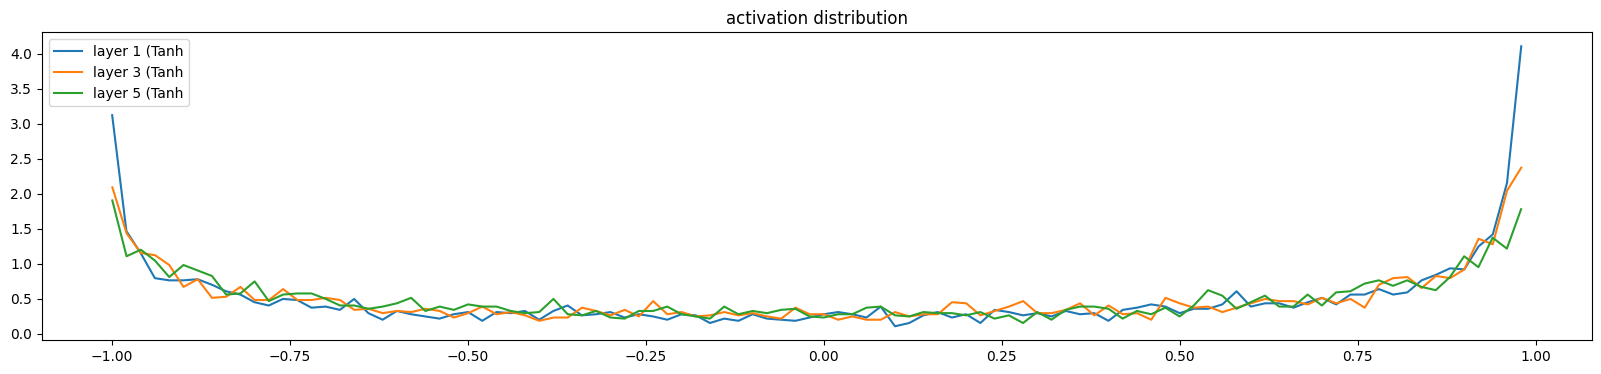

In [286]:
visualize_activation_distribution(C_layers_parameters_ex1_normal_init[1])

layer 1 (      Tanh): mean +0.000017, std 3.286545e-03
layer 3 (      Tanh): mean -0.000038, std 2.990445e-03
layer 5 (      Tanh): mean +0.000027, std 2.497591e-03


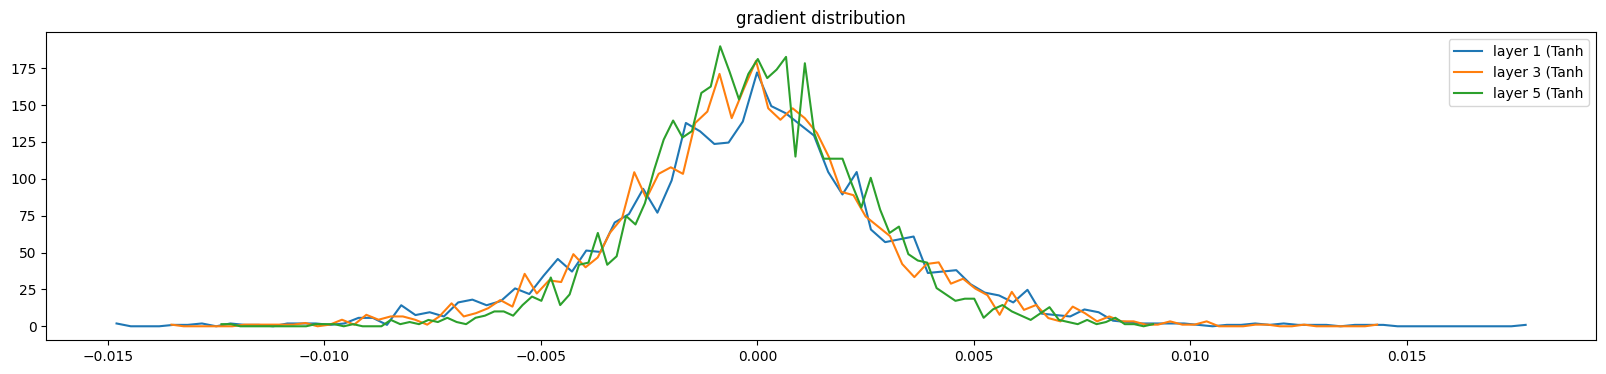

In [287]:
visualize_gradient_distribution(C_layers_parameters_ex1_normal_init[1])

weight   (27, 10) | mean +0.000557 | std 1.215627e-02 | grad:data ratio 1.297779e-02
weight  (30, 100) | mean +0.000147 | std 9.622788e-03 | grad:data ratio 3.160462e-02
weight (100, 100) | mean +0.000034 | std 6.866761e-03 | grad:data ratio 4.045969e-02
weight (100, 100) | mean +0.000024 | std 5.306865e-03 | grad:data ratio 3.159810e-02
weight  (100, 27) | mean -0.000000 | std 1.885079e-02 | grad:data ratio 2.555685e-01


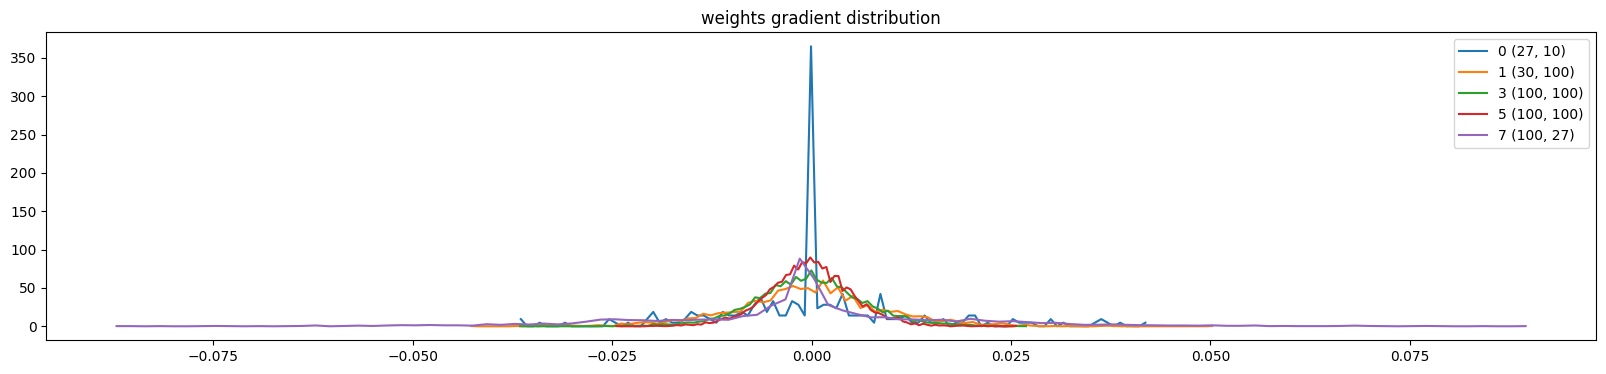

In [288]:
visualize_weight_gradient_distribution(C_layers_parameters_ex1_normal_init[2])

In [289]:
# put layers into eval mode
for layer in C_layers_parameters_ex1_normal_init[1]:
  layer.training = False
split_loss(dataset, 'train', C_layers_parameters_ex1_normal_init[0], C_layers_parameters_ex1_normal_init[1])
split_loss(dataset, 'test', C_layers_parameters_ex1_normal_init[0], C_layers_parameters_ex1_normal_init[1])

train 2.3742525577545166
test 2.374556064605713


### Visualization @ train

In [290]:
C_layers_parameters_ex1_normal_train = build_nn_ex1_normal()
ex1_normal_train_lossi, ex1_zeros_normal_ud = train(C_layers_parameters_ex1_normal_train, Xtr, Ytr)

26297
      0/ 200000: 3.3136
  10000/ 200000: 1.9839
  20000/ 200000: 2.2189
  30000/ 200000: 2.1922
  40000/ 200000: 1.9778
  50000/ 200000: 2.2118
  60000/ 200000: 2.1959
  70000/ 200000: 2.3882
  80000/ 200000: 2.3455
  90000/ 200000: 2.2814
 100000/ 200000: 2.6782
 110000/ 200000: 2.0711
 120000/ 200000: 1.8310
 130000/ 200000: 2.2582
 140000/ 200000: 2.2509
 150000/ 200000: 2.0821
 160000/ 200000: 1.8529
 170000/ 200000: 2.0093
 180000/ 200000: 2.0941
 190000/ 200000: 1.8138


layer 1 (      Tanh): mean +0.06, std 0.89, saturated: 56.97%
layer 3 (      Tanh): mean -0.01, std 0.92, saturated: 65.31%
layer 5 (      Tanh): mean -0.03, std 0.89, saturated: 52.44%


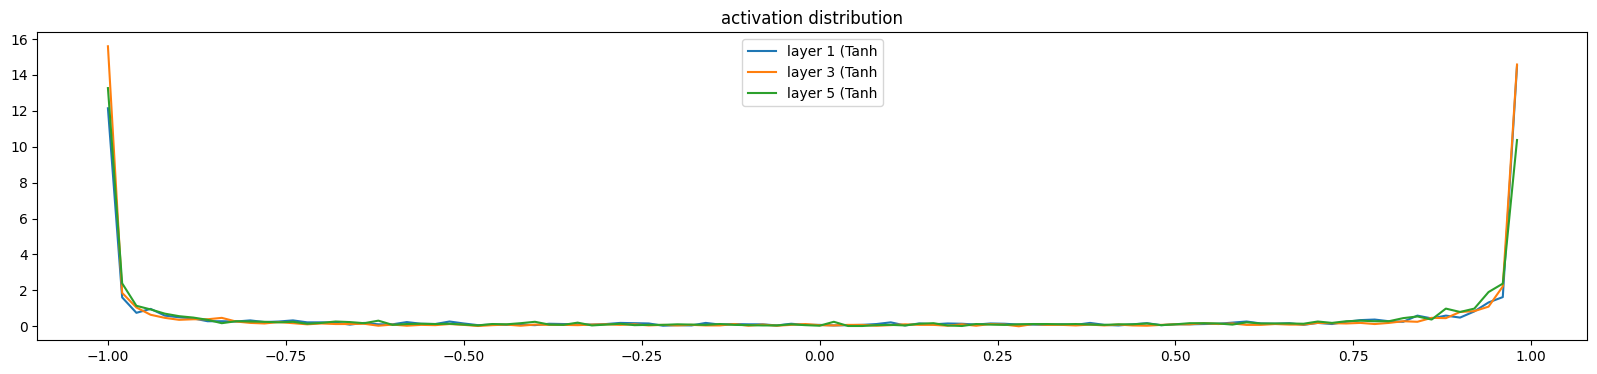

In [291]:
visualize_activation_distribution(C_layers_parameters_ex1_normal_train[1])

layer 1 (      Tanh): mean +0.000197, std 4.896166e-03
layer 3 (      Tanh): mean -0.000182, std 5.059227e-03
layer 5 (      Tanh): mean +0.000195, std 5.828653e-03


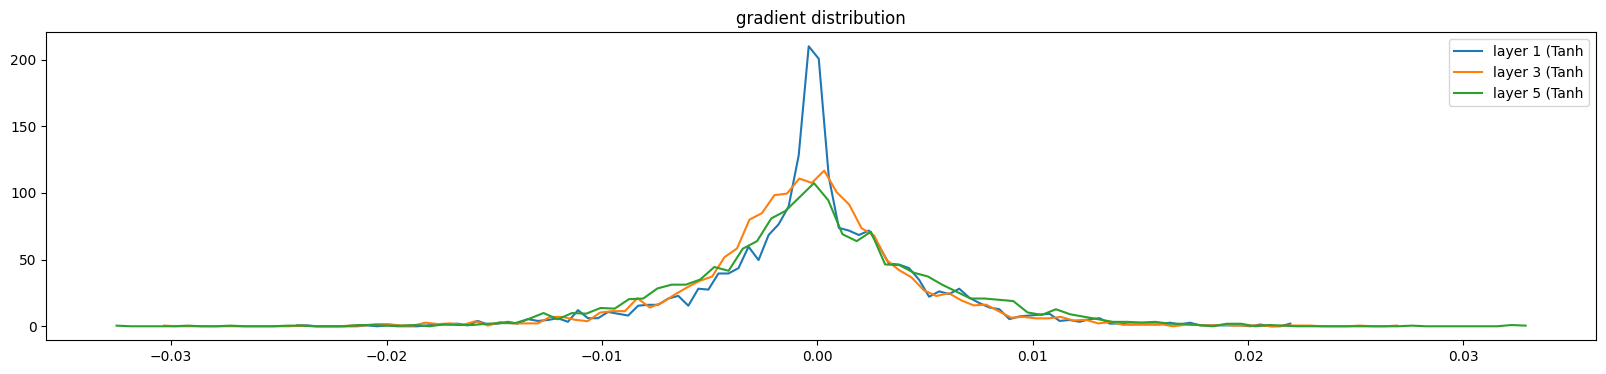

In [292]:
visualize_gradient_distribution(C_layers_parameters_ex1_normal_train[1])

weight   (27, 10) | mean +0.002163 | std 1.979936e-02 | grad:data ratio 1.638079e-02
weight  (30, 100) | mean +0.000030 | std 1.177700e-02 | grad:data ratio 2.143060e-02
weight (100, 100) | mean -0.000024 | std 7.081840e-03 | grad:data ratio 2.088634e-02
weight (100, 100) | mean -0.000163 | std 8.492586e-03 | grad:data ratio 2.784037e-02
weight  (100, 27) | mean -0.000000 | std 2.747502e-02 | grad:data ratio 1.214894e-01


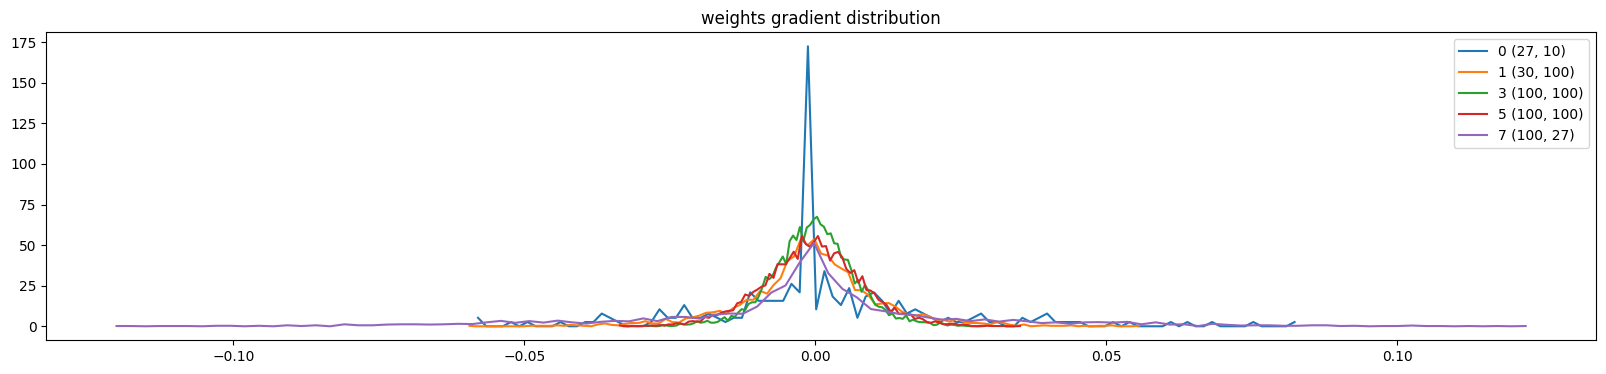

In [293]:
visualize_weight_gradient_distribution(C_layers_parameters_ex1_normal_train[2])

In [ ]:
# put layers into eval mode
for layer in C_layers_parameters_ex1_normal_train[1]:
  layer.training = False
split_loss(dataset, 'train', C_layers_parameters_ex1_normal_train[0], C_layers_parameters_ex1_normal_train[1])
split_loss(dataset, 'test', C_layers_parameters_ex1_normal_train[0], C_layers_parameters_ex1_normal_train[1])

# Exercise 2
*  BatchNorm, unlike other normalization layers like LayerNorm/GroupNorm etc. has the big advantage that after training, the batchnorm gamma/beta can be "folded into" the weights of the preceeding Linear layers, effectively erasing the need to forward it at test time. Set up a small 3-layer MLP with batchnorms, train the network, then "fold" the batchnorm gamma/beta into the preceeding Linear layer's W,b by creating a new W2, b2 and erasing the batch norm. Verify that this gives the same forward pass during inference. i.e. we see that the batchnorm is there just for stabilizing the training, and can be thrown out after training is done! pretty cool.

In [261]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(network_random_seed) # for reproducibility

def build_nn_ex2():
  C = torch.randn((vocab_size, n_embd),            generator=g)
  layers = [
    Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
  ]

  parameters = [C] + [p for layer in layers for p in layer.parameters()]
  print(sum(p.nelement() for p in parameters)) # number of parameters in total
  for p in parameters:
    p.requires_grad = True

  with torch.no_grad():
    # last layer: make less confident
    layers[-1].gamma *= 0.1

  return (C, layers, parameters)

In [262]:
C_layers_parameters_ex2_train = build_nn_ex2()
ex2_train_lossi, ex2_train_ud = train(C_layers_parameters_ex2_train, Xtr, Ytr)

6224
      0/ 200000: 3.2898
  10000/ 200000: 2.3681
  20000/ 200000: 2.4114
  30000/ 200000: 2.3445
  40000/ 200000: 2.1971
  50000/ 200000: 2.5147
  60000/ 200000: 2.1033
  70000/ 200000: 2.3936
  80000/ 200000: 2.2000
  90000/ 200000: 2.4622
 100000/ 200000: 1.8569
 110000/ 200000: 2.1711
 120000/ 200000: 2.1990
 130000/ 200000: 2.2347
 140000/ 200000: 2.3214
 150000/ 200000: 2.1559
 160000/ 200000: 2.1153
 170000/ 200000: 1.8654
 180000/ 200000: 2.0728
 190000/ 200000: 2.0492


In [263]:
# Inference with BatchNorm
for layer in C_layers_parameters_ex2_train[1]:
  layer.training = False
split_loss(dataset, 'train', C_layers_parameters_ex2_train[0], C_layers_parameters_ex2_train[1])
split_loss(dataset, 'test', C_layers_parameters_ex2_train[0], C_layers_parameters_ex2_train[1])

train 2.1077704429626465
test 2.1359426975250244


In [265]:
# Folding BatchNorm layers into the preceeding Linear Layer weights
C_fold = C_layers_parameters_ex2_train[0]
layers_fold = [
  Linear(n_embd * block_size, n_hidden, bias=False), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False),
]

batch_norm1 = C_layers_parameters_ex2_train[1][1]
layers_fold[0].weight =  C_layers_parameters_ex2_train[1][0].weight * batch_norm1.gamma / (batch_norm1.running_var + batch_norm1.eps)**0.5
layers_fold[0].bias = batch_norm1.gamma * (-batch_norm1.running_mean  / (batch_norm1.running_var + batch_norm1.eps)**0.5) + batch_norm1.beta

batch_norm4 = C_layers_parameters_ex2_train[1][4]
layers_fold[2].weight =  C_layers_parameters_ex2_train[1][3].weight * batch_norm4.gamma / (batch_norm4.running_var + batch_norm4.eps)**0.5
layers_fold[2].bias = batch_norm4.gamma * (-batch_norm4.running_mean  / (batch_norm4.running_var + batch_norm4.eps)**0.5) + batch_norm4.beta

In [266]:
# Inference without BatchNorm
split_loss(dataset, 'train', C_fold, layers_fold)
split_loss(dataset, 'test', C_fold, layers_fold)

train 2.1077704429626465
test 2.1359424591064453
